### feature importance algorithms simulations

#### MNIST simulation

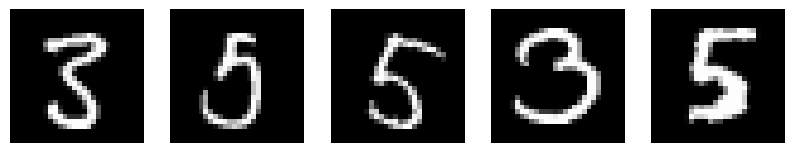

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor()])

# Download and load the training data
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Filter the dataset for labels 3 and 5
indices = np.where((mnist.targets == 3) | (mnist.targets == 5))[0]
filtered_mnist = torch.utils.data.Subset(mnist, indices)

# Function to display images
def show_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(10, 2))
    for i in range(num_images):
        image, label = dataset[np.random.randint(len(dataset))]
        axes[i].imshow(image.squeeze(), cmap='gray')
        # axes[i].set_title(f'Label: {label}')
        axes[i].axis('off')
    plt.show()

# Display random images
show_images(filtered_mnist)


In [2]:
X = []
y = []
for image, label in filtered_mnist:
    X.append(image.numpy().flatten())
    y.append(label)
X = np.array(X)
y = np.array(y)
print(X.shape, y.shape)

(11552, 784) (11552,)


In [3]:
from treeple import PatchObliqueRandomForestClassifier, ObliqueRandomForestClassifier
from tqdm import tqdm
import pickle
import gc
import os
from sklearn.utils import shuffle
from joblib import Parallel, delayed
import scipy.stats as ss

In [4]:
def train_model(ii, X, y, clf):
    rng = np.random.default_rng(ii)
    bootstrap_idx = rng.choice(len(X), size=len(X), replace=True)
    if clf == "MORF":
        orf = PatchObliqueRandomForestClassifier(
            n_estimators=1,
            max_patch_dims=np.array((5, 2)),
            data_dims=np.array((28, 28)),
            n_jobs=1,
            max_features='sqrt',
            bootstrap=False,
            verbose=1,
            oob_score=False,
            random_state=ii,
        )
    elif clf == "SPORF":
        orf = ObliqueRandomForestClassifier(
            n_estimators=1,
            n_jobs=1,
            max_features='sqrt',
            bootstrap=False,
            verbose=1,
            oob_score=False,
            random_state=ii,
            
        )

    orf.fit(X[bootstrap_idx, :], y[bootstrap_idx])
    oob_idx = np.setdiff1d(np.arange(len(y)), bootstrap_idx)
    oob_decisions = orf.predict_proba(X[oob_idx, :])
    padded_oob_decisions = np.zeros((len(y), oob_decisions.shape[1]))
    padded_oob_decisions[oob_idx, :] = oob_decisions
    
    return orf.feature_importances_, padded_oob_decisions

### Jayanta's original version of Feature Importance Testing

In [ ]:
# def statistics(feature_importance, idx, n_estimators=100):
#     """Helper function to calculate feature importance test statistic."""
#     stat = np.zeros(len(feature_importance[0]))
#     for ii in range(n_estimators):
#         r = ss.rankdata(1 - feature_importance[idx[ii]], method='max')
#         r_0 = ss.rankdata(1 - feature_importance[idx[n_estimators + ii]], method='max')
#         stat += (r_0 > r) * 1

#     stat /= n_estimators
#     return stat

# def perm_stat(feature_importance, n_estimators=100):
#     """Helper function to calculate the null distribution."""
#     idx = list(range(2 * n_estimators))
#     np.random.shuffle(idx)
#     return statistics(feature_importance, idx, n_estimators)

# def test(feature_importance, n_repeats=1000, n_jobs=-1, n_est=100):
#     """Permutation test to compare real vs shuffled feature importance."""
#     stat = statistics(feature_importance, list(range(2 * n_est)), n_est)
#     null_stat = Parallel(n_jobs=n_jobs)(
#         delayed(perm_stat)(feature_importance, n_estimators=n_est)
#         for _ in tqdm(range(n_repeats), desc="Calculating null distribution")
#     )
#     count = np.sum((null_stat >= stat) * 1, axis=0)
#     p_val = (1 + count) / (1 + n_repeats)
#     return stat, p_val

#### My version of Feature Importance Testing

In [5]:
from statsmodels.stats.multitest import multipletests
from scipy import stats as ss
from joblib import Parallel, delayed
import numpy as np
from tqdm import tqdm

def compute_ranks(feature_importance):
    """Precompute ranks using 'max' method to match original behavior."""
    return np.apply_along_axis(lambda x: ss.rankdata(1 - x, method='max'), axis=1, arr=feature_importance)

def statistics(ranks, idx, n_estimators=100):
    """
    Optimized function that calculates the feature importance test statistic.
    Ensures correct rank ordering and functionality preservation.
    """
    stat = np.zeros(ranks.shape[1])
    
    for ii in range(n_estimators):
        r = ranks[idx[ii]]
        r_0 = ranks[idx[n_estimators + ii]]
        stat += (r_0 > r) * 1  # Boolean comparison, same as original
        
    stat /= n_estimators
    return stat

def perm_stat(ranks, n_estimators=100):
    """
    Helper function that calculates the null distribution.
    """
    rng = np.random.default_rng()
    idx = rng.permutation(2 * n_estimators)
    return statistics(ranks, idx, n_estimators)

def test(feature_importance, n_repeats=1000, n_jobs=-1, n_est=100):
    """
    Permutation test to compare real vs shuffled feature importance.
    """
    # Precompute ranks once using the correct method
    ranks = compute_ranks(feature_importance)

    # Compute actual statistic
    stat = statistics(ranks, np.arange(2 * n_est), n_est)

    # Parallel computation of null distribution
    null_stat = np.array(Parallel(n_jobs=n_jobs)(
        delayed(perm_stat)(ranks, n_estimators=n_est)
        for _ in tqdm(range(n_repeats), desc="Calculating null distribution")
    ))

    # Compute p-values
    count = np.sum(null_stat >= stat, axis=0)
    p_val = (1 + count) / (1 + n_repeats)

    return stat, p_val


In [6]:
def get_p(feat_imp_all, feat_imp_all_rand, n_repeats=5000):
    _, p = test(
                np.concatenate((feat_imp_all, feat_imp_all_rand)),
                n_repeats = n_repeats,
                n_jobs = -1,
                n_est = len(feat_imp_all)
    )

    # Apply Bonferroni-Holm correction
    p_corrected = multipletests(p, method="holm")[1]
    return p_corrected

In [ ]:
def feat_imp_test(X, y, n_est, n_rep, clf):
    results = Parallel(n_jobs=-1)(
        delayed(train_model)(ii, X, y, clf) for ii in tqdm(range(n_est))
    )

    feat_imp_all, _ = zip(*results)
    y_shuffled = shuffle(y, random_state=0)

    results = Parallel(n_jobs=-1)(
        delayed(train_model)(ii, X, y_shuffled, clf) for ii in tqdm(range(n_est))
    )
    feat_imp_all_rand, _ = zip(*results)
    corrected_p = get_p(feat_imp_all, feat_imp_all_rand, n_rep)
    return corrected_p

In [39]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import shap
import lime.lime_tabular
from joblib import Parallel, delayed
from tqdm import tqdm

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0)

n_est = 5000
rf = RandomForestClassifier(n_estimators=n_est, random_state=0)
rf.fit(X_train, y_train)
rf_importances = rf.feature_importances_
explainer = shap.Explainer(rf, X_train)
test_instance = X_train[0].reshape(1, -1)
shap_values = explainer(test_instance)
shap_importances = np.abs(shap_values.values).mean(axis=2).reshape(-1)

explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    X_train, mode="classification", feature_names=[f"pixel_{i}" for i in range(X_train.shape[1])],
    discretize_continuous=True
)
lime_exp = explainer_lime.explain_instance(test_instance.flatten(), rf.predict_proba, num_features=X_train.shape[1])
lime_importances = np.array([score for _, score in lime_exp.as_list()])

def evaluate_with_top_features(num_features, rand_idx, n_est):
    """Evaluates classification accuracy with top `num_features` selected by different methods."""
    # Evaluate with RF
    top_features = np.argsort(rf_importances)[-num_features:]
    X_val_ = X_val[:, top_features]
    X_test_ = X_test[:, top_features]
    clf = RandomForestClassifier(n_estimators=n_est, random_state=rand_idx).fit(X_val_, y_val)
    acc_rf = clf.score(X_test_, y_test)

    # Evaluate with SHAP
    top_features = np.argsort(shap_importances)[-num_features:]
    X_val_ = X_val[:, top_features]
    X_test_ = X_test[:, top_features]
    clf = RandomForestClassifier(n_estimators=n_est, random_state=rand_idx).fit(X_val_, y_val)
    acc_shap = clf.score(X_test_, y_test)

    # Evaluate with LIME
    top_features = np.argsort(lime_importances)[-num_features:]
    X_val_ = X_val[:, top_features]
    X_test_ = X_test[:, top_features]
    clf = RandomForestClassifier(n_estimators=n_est, random_state=rand_idx).fit(X_val_, y_val)
    acc_lime = clf.score(X_test_, y_test)

    return {"num_features": num_features, "rand_idx": rand_idx,
            "acc_RF": acc_rf, "acc_SHAP": acc_shap, "acc_LIME": acc_lime}


In [40]:
num_features_list = [2**i for i in range(10)] + [784]
n_rep = 5
rand_indices = range(n_rep)

results = Parallel(n_jobs=-1)(
    delayed(evaluate_with_top_features)(num_features, rand_idx, n_est)
    for num_features in tqdm(num_features_list) for rand_idx in rand_indices
)


df_results = pd.DataFrame(results)

df_melted = df_results.melt(id_vars=["num_features", "rand_idx"], 
                            value_vars=["acc_RF", "acc_SHAP", "acc_LIME"], 
                            var_name="Method", value_name="Accuracy")

df_stats = df_melted.groupby(["num_features", "Method"])["Accuracy"].agg(["mean", "std"]).reset_index()

100%|██████████| 11/11 [00:00<00:00, 7962.95it/s]


In [41]:
# Compute p-values to determine significant features

# corrected_p = feat_imp_test(X_train, y_train, n_est, 100000, "MORF")
corrected_p = feat_imp_test(X_train, y_train, n_est, 100000, "SPORF")
top_features = corrected_p < 0.05
X_val_ = X_val[:, top_features]
X_test_ = X_test[:, top_features]
clf = RandomForestClassifier(n_estimators=n_est, random_state=0).fit(X_val_, y_val)
acc_fit = clf.score(X_test_, y_test)


Calculating null distribution: 100%|██████████| 100000/100000 [04:28<00:00, 371.91it/s]


In [42]:
def train_FIT(rand_idx, X_val_, y_val, X_test_, y_test):
    clf = RandomForestClassifier(n_estimators=n_est, random_state=rand_idx)
    clf.fit(X_val_, y_val)
    return clf.score(X_test_, y_test)

acc_fit_all = Parallel(n_jobs=-1)(
    delayed(train_FIT)(rand_idx, X_val_, y_val, X_test_, y_test)
    for rand_idx in rand_indices
)
acc_fit_all


[0.825, 0.83, 0.835, 0.83, 0.815]

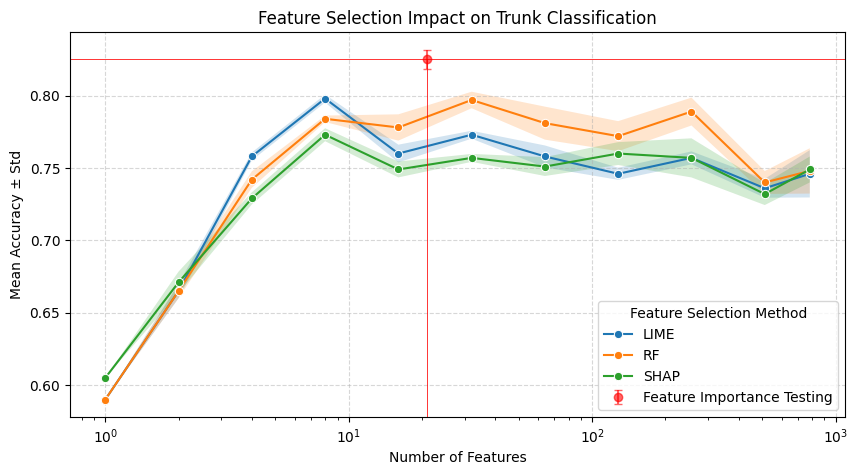

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

jitter_strength = 7  
plt.figure(figsize=(10, 5))

# Plot accuracy trends with error bands
sns.lineplot(x="num_features", y="mean", hue="Method", data=df_stats, marker="o")

for method in df_stats["Method"].unique():
    subset = df_stats[df_stats["Method"] == method]
    plt.fill_between(subset["num_features"], subset["mean"] - subset["std"], subset["mean"] + subset["std"], alpha=0.2)

# Plot rf_fit as an individual point with error bar
rf_x = sum(top_features)  # Number of selected features
acc_fit_std = np.std(acc_fit_all)  # Calculate standard deviation for error bar

plt.errorbar(
    rf_x, 
    acc_fit, 
    yerr=acc_fit_std, 
    fmt='o', 
    color="red", 
    alpha=0.6, 
    label="Feature Importance Testing", 
    capsize=3  # Add caps to error bars for better visibility
)

y_min, y_max = plt.ylim()
y_pos_normalized = (acc_fit - y_min) / (y_max - y_min)

# Add solid red vertical line
plt.axvline(x=rf_x, color="red", linestyle="-", alpha=0.8, ymax=y_pos_normalized, linewidth=0.7)

# Identify the feature count where other methods reach the mean accuracy of rf_fit
for method in df_stats["Method"].unique():
    subset = df_stats[df_stats["Method"] == method].sort_values("num_features")
    
    # Find intersection point using interpolation
    x_values = subset["num_features"].values
    y_values = subset["mean"].values

    if (y_values.min() <= acc_fit <= y_values.max()):  # Check if intersection is within the range
        method_x = np.interp(acc_fit, y_values, x_values)  # Find exact x for y=acc_fit

        # Get the color used in the seaborn plot
        method_color = sns.color_palette()[list(df_stats["Method"].unique()).index(method)]

        # Normalize y position
        method_y_pos_normalized = (acc_fit - y_min) / (y_max - y_min)

        # Add a vertical dotted line in the method's color at the exact intersection point
        plt.axvline(x=method_x, linestyle="dotted", color=method_color, alpha=0.7, ymax=method_y_pos_normalized)

plt.axhline(y=acc_fit, color="red", linestyle="-", alpha=0.8, linewidth=0.7)
plt.xscale("log")
plt.xlabel("Number of Features")
plt.ylabel("Mean Accuracy ± Std")
plt.title("Feature Selection Impact on Trunk Classification")
# plt.title("Feature Selection Impact on MNIST 3/5 Classification")

handles, labels = plt.gca().get_legend_handles_labels()
labels[:3] = ["LIME", "RF", "SHAP"]
plt.legend(handles, labels, title="Feature Selection Method")

plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


#### Trunk simulation

In [38]:
from treeple.datasets import make_trunk_classification

n_samples = 1000
n_dim = 784
X, y = make_trunk_classification(n_samples=n_samples, n_dim=n_dim, n_informative=600, seed=0)